In [1]:
import random
import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

from tqdm.auto import tqdm
from aging.plotting import (
    figure,
    format_plots,
    add_identity,
    legend,
    PLOT_CONFIG,
    save_factory,
    COLORMAPS,
)
from copy import deepcopy
from operator import or_
from toolz import reduce, valmap, keyfilter, pluck, drop, merge
from aging.behavior.bio_age_model import fit_model, masked_xval
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr
from toolz import sliding_window
from collections import defaultdict

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_predict, ParameterGrid

In [2]:
format_plots()
saver = save_factory(PLOT_CONFIG.save_path / "fig4-longv1-lab-comments", tight_layout=False)

In [3]:
def zscore(ser: pd.Series):
    return (ser - ser.mean()) / ser.std()


def demean(ser: pd.Series):
    return ser - ser.mean()


def quantile(n):
    def percentile_(x):
        return x.quantile(n)

    percentile_.__name__ = "q_{:0.02f}".format(n)
    return percentile_


def compute_classifier(df, seed=0):
    pipe = make_pipeline(
        StandardScaler(),
        SVC(kernel="linear", class_weight="balanced"),
    )

    preds = cross_val_predict(
        pipe,
        df[["beh_age"]],
        df["classes"],
        cv=StratifiedKFold(n_splits=6, shuffle=True, random_state=seed),
    )
    return accuracy_score(df["classes"], preds), preds


def minimizer(corrs):
    return corrs['Death'].iloc[-11:].mean()

## Load the death predictor data

In [4]:
death_df = pd.read_csv('/home/wg41/code/ontogeny/notebooks/exploration/win/death-predictor/death-predictor-data.csv').ffill()
death_df['Death'] = pd.to_datetime(death_df['Death'])

death_map = death_df.set_index('id')[['Death']].drop('04_02')
death_map['death_rank'] = death_map['Death'].rank()

In [5]:
def bin_age(df, bins):
    return pd.cut(df.reset_index()['age'], bins, labels=False)

In [6]:
to_remove = [
    "e4f1076b",
    "3867c517",
    "60e82cb4",
]

In [7]:
def load_long_df2(n_bins: "Optional[int]" = 75):
    keep_syllables = np.loadtxt(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt",
        dtype=int,
    )
    df = pd.read_parquet(
        # "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_males_raw_counts_matrix_v00.parquet"
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_males_raw_counts_matrix_v00.parquet"
    )
    df = df[keep_syllables]
    mask = df.index.get_level_values("age") < 100
    df = df[mask].copy()

    masks = []
    for uuid in to_remove:
        m = df.reset_index()["uuid"].str.startswith(uuid)
        masks.append(m)
    mask = np.array(reduce(or_, masks), dtype=bool)
    df = df[~mask].copy()

    size_df = pd.read_parquet(
        # '/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_males_mouse_area_df_v00.parquet'
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_males_mouse_area_df_v00.parquet"
    )
    mask = size_df.index.get_level_values("age") < 100
    size_df = size_df[mask].copy()
    age_cut = pd.cut(size_df.index.get_level_values("age"), 19)

    size_df.loc[size_df["quant_0.5"] == 0, "quant_0.5"] = np.nan
    sizes_col = size_df["quant_0.5"]
    sizes_col = (
        sizes_col.groupby("mouse")
        .apply(lambda df: df.sort_index(level="age").interpolate())
        .droplevel(0)
    )

    # sizes_col = zscore(sizes_col.groupby(age_cut, observed=True).transform(demean))
    sizes_col = sizes_col.groupby(age_cut, observed=True).transform(zscore)
    sizes_col = sizes_col.fillna(0)
    sizes_col = sizes_col.loc[df.index]

    # make sure df matches sizes
    df = df.loc[sizes_col.index]

    if n_bins is not None:
        # subsample the dataset
        cut, bins = pd.cut(df.index.get_level_values("age"), n_bins, retbins=True)
        # tmp_df = df.groupby(['mouse', cut], observed=True).first()
        tmp_df = (
            df.reset_index()
            .groupby(["mouse", cut], observed=True)
            .first()
            .reset_index()
            .drop(columns=["level_1"])
            .set_index(["age", "mouse", "subject_name", "session_name", "uuid", "date"])
        )
        # mid_age = [round(v.left, 2) for v in tmp_df.index.get_level_values(1)]
        # tmp_df['age'] = mid_age
        # tmp_df = tmp_df.set_index('age', append=True).droplevel(1)

        sizes_col = (
            sizes_col.reset_index().groupby(["mouse", cut], observed=True).first()
        )
        sizes_col = (
            sizes_col.reset_index()
            .drop(columns=["level_1"])
            .set_index(["age", "mouse", "subject_name", "session_name", "uuid", "date"])
        )
        sizes_col = sizes_col.loc[tmp_df.index, "quant_0.5"]
    else:
        tmp_df = df

    age = jnp.array(tmp_df.index.get_level_values("age"))
    syllable_counts_jax = jnp.array(tmp_df.astype(float))

    label_encoder = OneHotEncoder(sparse_output=False, dtype=np.float32)
    mouse_ids = label_encoder.fit_transform(
        sizes_col.index.get_level_values("mouse").to_numpy()[:, None]
    ).T

    sort_idx = np.argsort(syllable_counts_jax.sum(0))[::-1]

    return tmp_df, syllable_counts_jax, age, sizes_col, mouse_ids, sort_idx, label_encoder

In [76]:
tmp_df, syllable_counts_jax, age, size_col, mouse_ids, sort_idx, labels = load_long_df2(None)

In [77]:
features = {
    "ages": age,  # models >= 1
    "counts": syllable_counts_jax + 1,  # models >= 1
    "sizes": size_col.to_numpy(),  # models > 1
    "mice": mouse_ids,
}

# age_sd = 5
age_sd = 0.18

hypparams = {
    "log_age": True,
    "min_age": 2,
    "max_age": 125,
    "age_sd": age_sd,
    "n_age_samples": 1000,
    "n_splines": 4,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_development_splines": 4,
    "scale": 150,
    "normalize_by_softmax": True,
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "n_animals": len(mouse_ids),
    "lr": 0.25,
    "n_opt_iter": 450,
    "log_scale_sd": True,
}

In [79]:
residual_map = {}
for i in tqdm(np.linspace(0.12, 0.24, 12 * 2 + 1)):
    hyp_copy = deepcopy(hypparams)
    hyp_copy['age_sd'] = i
    mdl = fit_model(features, hyp_copy, 5, return_loss_on_error=True)
    if len(mdl) == 1:
        print(hypparams['n_opt_iter'] - np.isnan(mdl['loss']).sum())
        continue
    mdl_residuals = mdl['true_ages'] - mdl['bio_ages']
    mdl_residuals = mdl_residuals[mdl['true_ages'] > 45]
    avg_mdl_residuals = np.median(np.abs(mdl_residuals))
    residual_map[i] = avg_mdl_residuals
residual_map = pd.Series(residual_map)

  0%|          | 0/25 [00:00<?, ?it/s]

[None]

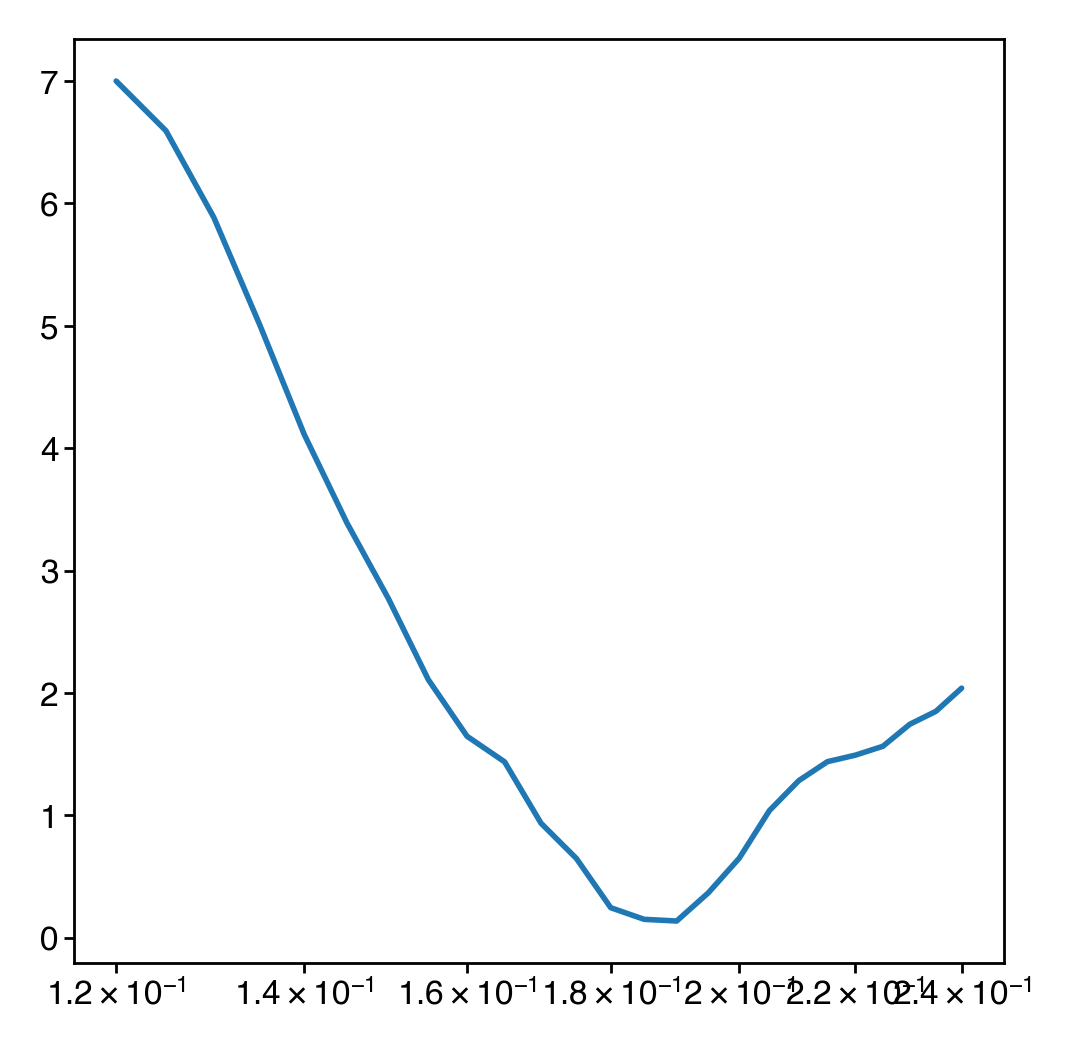

In [80]:
loss = (residual_map - 9.744186 + 0.5).abs()
ax = loss.plot()
ax.set(xscale='log')

In [81]:
loss.idxmin()

0.19

In [82]:
hypparams['age_sd'] = loss.idxmin()
hypparams['age_sd']

0.19

In [104]:
hypparams['age_sd'] = 0.3

In [105]:
mdl = fit_model(features, hypparams, 5, return_loss_on_error=True)
tmp_df['beh_age'] = mdl['bio_ages']

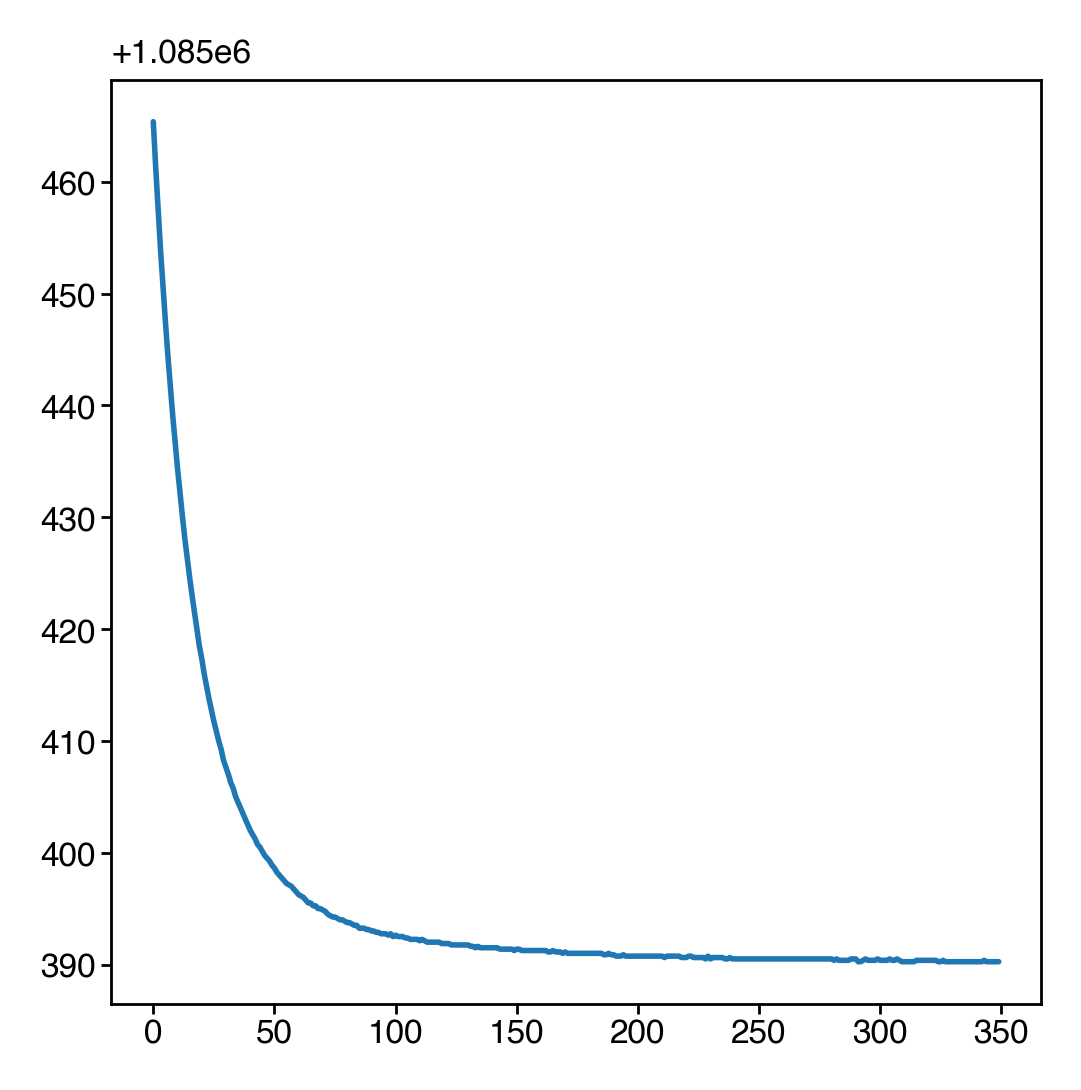

In [106]:
plt.plot(mdl['loss'][100:])

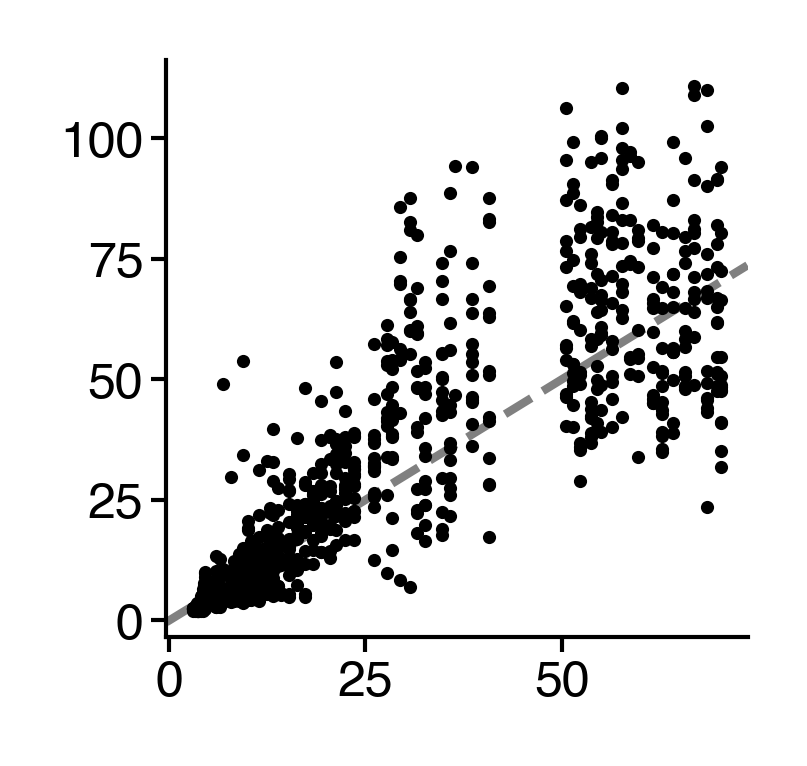

In [107]:
fig = figure(1.25, 1.25)
plt.scatter(mdl['true_ages'], mdl['bio_ages'], c='k', s=2.5, lw=0)
a = add_identity(plt.gca(), c='gray', ls='--', zorder=-1)
sns.despine()

## Join death and behavior

In [108]:
n_classes = 4

reset_df = tmp_df.reset_index()
def make_death_df(min_age, max_age):

    joined = reset_df[reset_df['age'].between(min_age, max_age)].merge(
        death_map.reset_index(), left_on="mouse", right_on="id"
    ).dropna(subset=["Death"])

    classes = pd.qcut(joined["Death"], n_classes, labels=False)
    joined['classes'] = classes
    return joined

### Make functions for plotting

In [109]:
def fit_classifier(data, n_fits=100):
    accs = []
    for seed in range(n_fits):
        acc, p = compute_classifier(data, seed=seed)
        accs.append(acc)
    print("Observed fit")
    print(n_classes, round(np.log2(np.mean(accs) / (1 / n_classes)), 2))

    # shuffle
    shuffs = []
    for i in tqdm(range(100)):
        shuff_df = data.copy()
        shuff_df['beh_age'] = shuff_df['beh_age'].sample(frac=1, replace=False, random_state=i).to_numpy()
        # shuffle ages within age chunks rather than across everything to remove individual biases
        acc, p = compute_classifier(shuff_df, seed=i)
        shuffs.append(acc)
    print("Shuffle fit")
    print(n_classes, round(np.log2(np.mean(shuffs) / (1 / n_classes)), 2))
    return accs, shuffs

def plot_model(accs, shuffs, name):
    fig = figure(0.55, 1.3)
    ax = sns.boxplot(data=[accs, shuffs], palette=['#333', 'silver'], showfliers=False, showcaps=False)
    ax.axhline(1 / n_classes, color='k', ls='--')
    ax.set(xticklabels=["Observed", "Shuffle"], ylabel="Held-out accuracy", ylim=(0.11, 0.45))
    ax.tick_params(axis='x', rotation=90)
    sns.despine()
    saver(fig, name)

## Try classifying early/late death times 

Observed fit
4 0.68


  0%|          | 0/100 [00:00<?, ?it/s]

Shuffle fit
4 -0.04


/tmp/ipykernel_27656/126220500.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=["Observed", "Shuffle"], ylabel="Held-out accuracy", ylim=(0.11, 0.45))


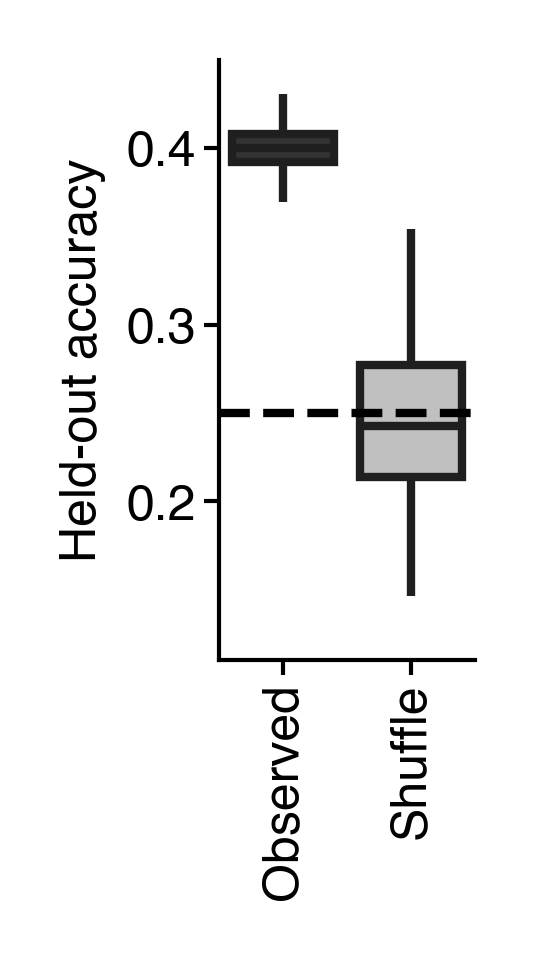

In [110]:
subset = make_death_df(56, 71)
accs, shuffs = fit_classifier(subset)
plot_model(accs, shuffs, "death-rank-classifier-via-bambi")

In [113]:
subset[['classes', 'beh_age']].corr(method='spearman')

,classes,beh_age
classes,1.00000,-0.11825
beh_age,-0.11825,1.00000


In [114]:
subset[['death_rank', 'beh_age']].corr(method='spearman')

,death_rank,beh_age
death_rank,1.000000,-0.088405
beh_age,-0.088405,1.000000


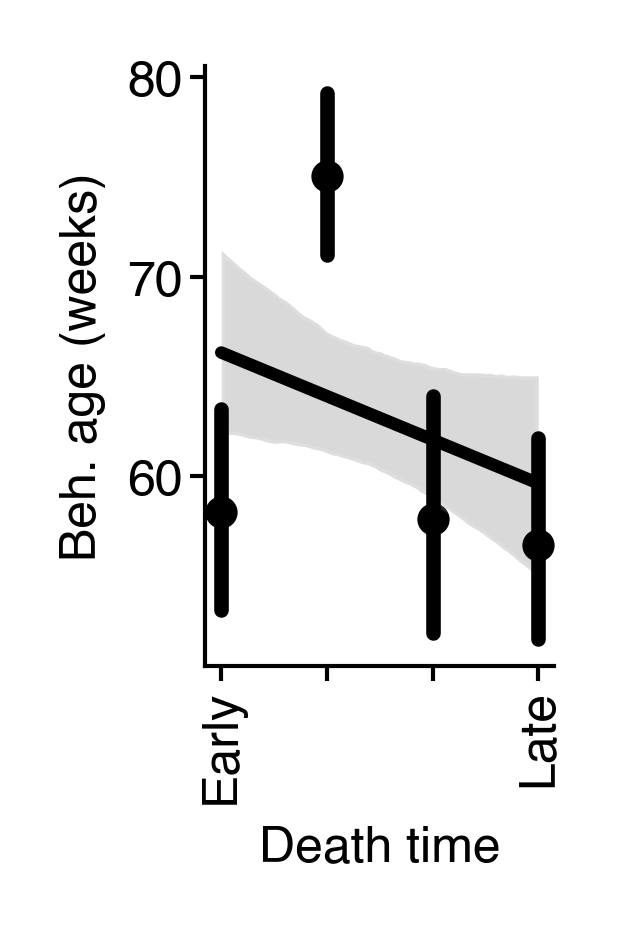

In [111]:
fig = figure(0.75, 1.3)
ax = sns.regplot(data=subset, x='classes', y='beh_age', x_bins=6, scatter_kws=dict(s=15, linewidths=0), color='k')
ax.set(ylabel="Beh. age (weeks)", xlabel="Death time", xticks=[0, 1, 2, 3], xticklabels=['Early', '', '', 'Late'])
ax.tick_params(axis='x', rotation=90)
sns.despine()
saver(fig, "bambi-beh-age-vs-death");

In [71]:
subset.head()

,age,mouse,subject_name,session_name,uuid,date,0,2,4,5,...,90,93,95,97,98,beh_age,id,Death,death_rank,classes
0,56.42857,01_01,01_01_206,206,dcf5cb0f-6228-4618-a53b-c71a04c990a4,2022-04-08 17:25:48,1.0,58.0,90.0,109.0,...,91.0,11.0,20.0,35.0,71.0,43.321602,01_01,2023-12-04,11.0,2
1,56.42857,01_02,01_02_206,206,c155e817-aaec-494e-ad50-23b17df1681d,2022-04-08 17:25:29,12.0,17.0,32.0,141.0,...,85.0,5.0,15.0,16.0,17.0,54.397232,01_02,2023-10-28,9.0,1
2,56.42857,01_03,01_03_206,206,90ca09fe-a2d3-420d-b80c-51deded8bb6d,2022-04-08 17:25:08,7.0,1.0,5.0,148.0,...,38.0,1.0,6.0,1.0,6.0,69.444817,01_03,2023-12-04,11.0,2
3,56.42857,01_04,01_04_206,206,d873e146-000a-4721-a2d7-92439480e48e,2022-04-08 17:26:07,3.0,35.0,83.0,67.0,...,95.0,0.0,30.0,14.0,72.0,47.060677,01_04,2024-01-08,14.0,3
4,56.42857,02_01,02_01_206,206,7df8ed35-6c8e-45a5-a21d-f4647e5fe730,2022-04-08 17:55:07,2.0,3.0,6.0,168.0,...,97.0,11.0,5.0,1.0,4.0,51.761242,02_01,2023-12-05,13.0,3


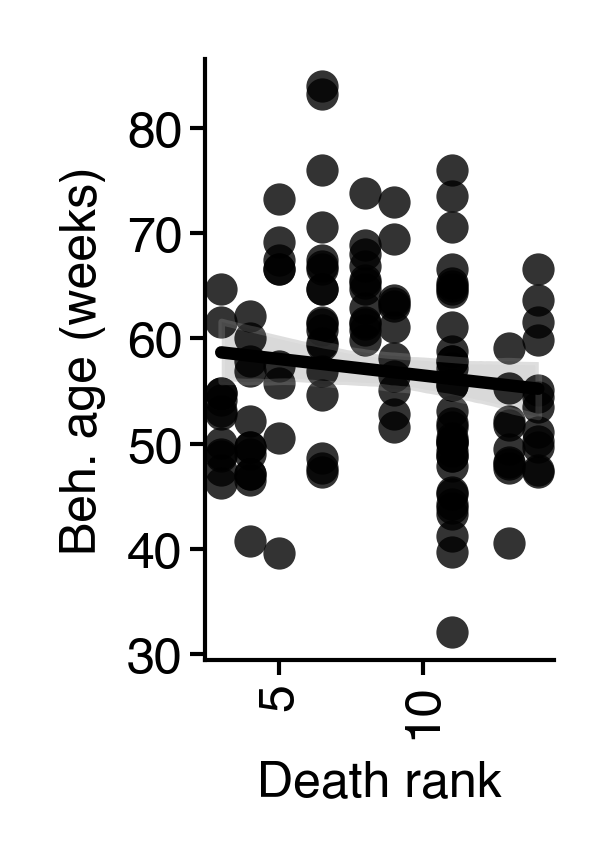

In [90]:
fig = figure(0.75, 1.3)
ax = sns.regplot(data=subset, x='death_rank', y='beh_age', scatter_kws=dict(s=15, linewidths=0), color='k')
ax.set(ylabel="Beh. age (weeks)", xlabel="Death rank")#, xticks=[0, 1, 2, 3], xticklabels=['Early', '', '', 'Late'])
ax.tick_params(axis='x', rotation=90)
sns.despine()

### Younger ages

Observed fit
4 -0.07


  0%|          | 0/100 [00:00<?, ?it/s]

Shuffle fit
4 -0.04


/tmp/ipykernel_27656/126220500.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=["Observed", "Shuffle"], ylabel="Held-out accuracy", ylim=(0.11, 0.45))


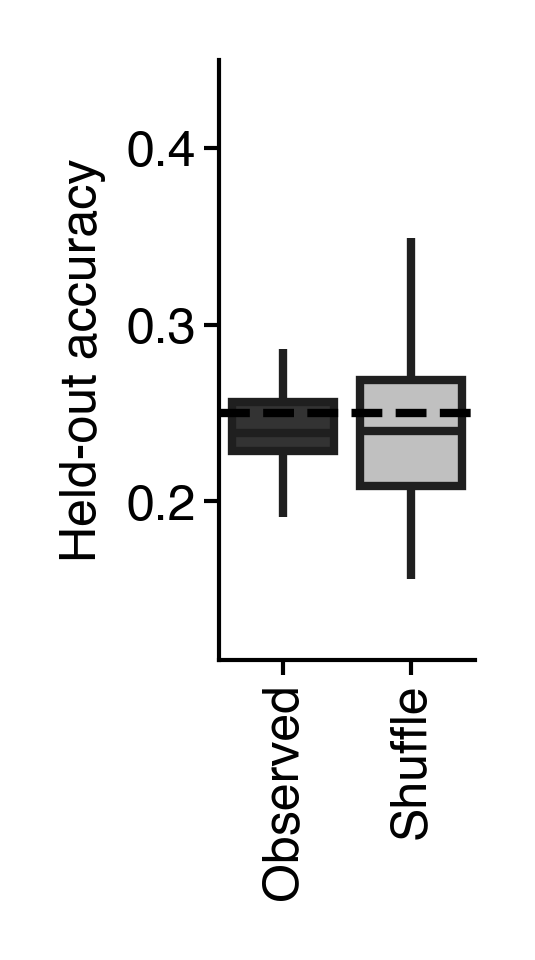

In [20]:
subset = make_death_df(0, 20)
accs, shuffs = fit_classifier(subset)
plot_model(accs, shuffs, "young-age-death-rank-classifier-via-bambi")

### Middler ages

Observed fit
4 0.36


  0%|          | 0/100 [00:00<?, ?it/s]

Shuffle fit
4 -0.03


/tmp/ipykernel_27656/126220500.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=["Observed", "Shuffle"], ylabel="Held-out accuracy", ylim=(0.11, 0.45))


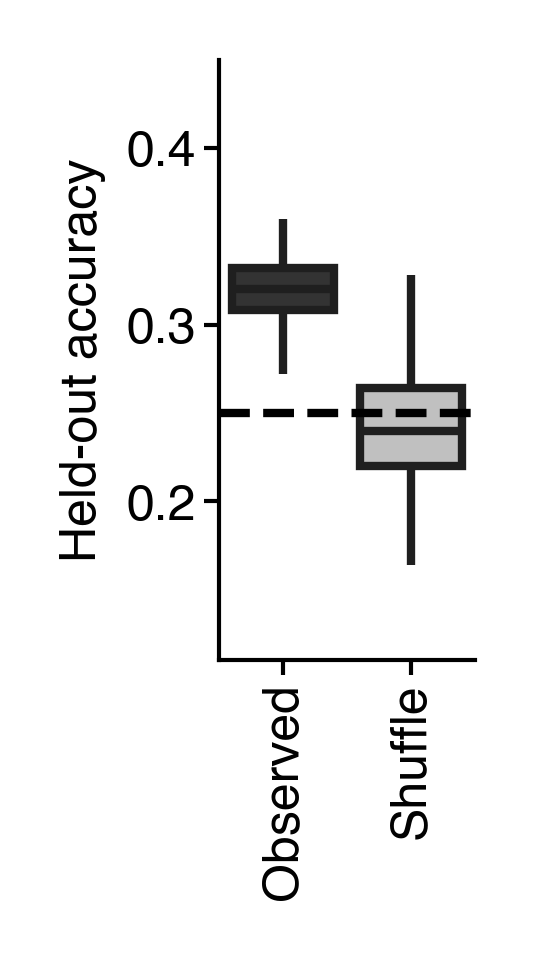

In [21]:
subset = make_death_df(20, 56)
accs, shuffs = fit_classifier(subset)
plot_model(accs, shuffs, "mid-age-death-rank-classifier-via-bambi")

### Correlate bio age with syllable use

In [22]:
subset = reset_df[reset_df['age'].between(56, 71)]
subset_join = subset.merge(
    death_map.reset_index(), left_on="mouse", right_on="id"
).dropna(subset=["Death"])

classes = pd.qcut(subset_join["Death"], n_classes, labels=False)
subset_join['classes'] = classes

In [23]:
subset_join.shape

(130, 69)

In [24]:
subset_join.head()

,age,mouse,subject_name,session_name,uuid,date,0,2,4,5,...,90,93,95,97,98,beh_age,id,Death,death_rank,classes
0,56.42857,01_01,01_01_206,206,dcf5cb0f-6228-4618-a53b-c71a04c990a4,2022-04-08 17:25:48,1.0,58.0,90.0,109.0,...,91.0,11.0,20.0,35.0,71.0,41.910526,01_01,2023-12-04,11.0,2
1,56.42857,01_02,01_02_206,206,c155e817-aaec-494e-ad50-23b17df1681d,2022-04-08 17:25:29,12.0,17.0,32.0,141.0,...,85.0,5.0,15.0,16.0,17.0,55.534798,01_02,2023-10-28,9.0,1
2,56.42857,01_03,01_03_206,206,90ca09fe-a2d3-420d-b80c-51deded8bb6d,2022-04-08 17:25:08,7.0,1.0,5.0,148.0,...,38.0,1.0,6.0,1.0,6.0,72.379646,01_03,2023-12-04,11.0,2
3,56.42857,01_04,01_04_206,206,d873e146-000a-4721-a2d7-92439480e48e,2022-04-08 17:26:07,3.0,35.0,83.0,67.0,...,95.0,0.0,30.0,14.0,72.0,46.479893,01_04,2024-01-08,14.0,3
4,56.42857,02_01,02_01_206,206,7df8ed35-6c8e-45a5-a21d-f4647e5fe730,2022-04-08 17:55:07,2.0,3.0,6.0,168.0,...,97.0,11.0,5.0,1.0,4.0,51.334503,02_01,2023-12-05,13.0,3


In [25]:
subset_join.columns = [str(x) for x in subset_join.columns]

In [26]:
syll_cols = [x for x in subset_join.columns if x.isdigit()]

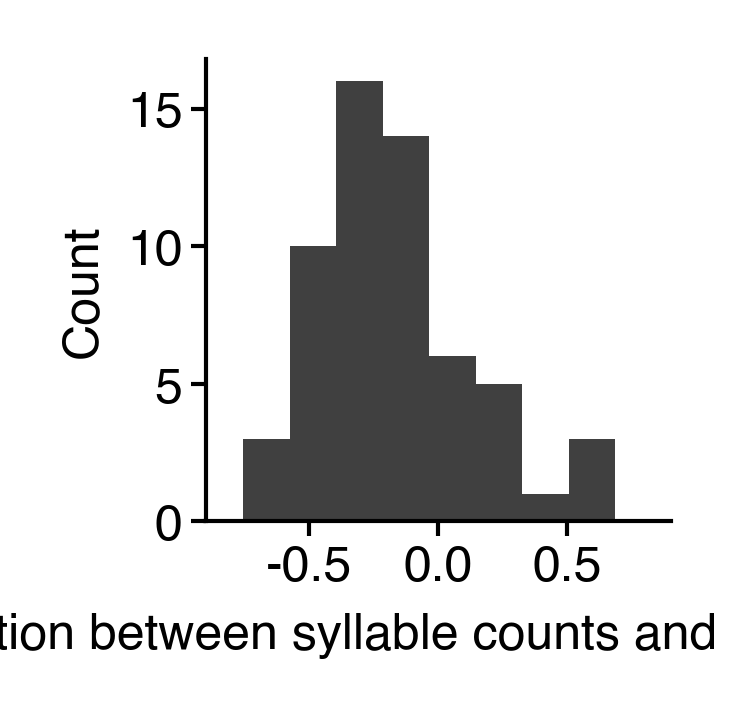

In [60]:
fig = figure(1, 1)
ax = sns.histplot(
    subset_join[syll_cols + ["beh_age"]]
    .corr(method="spearman")
    .loc["beh_age"]
    .drop("beh_age"),
    element="step",
    lw=0,
    color="k",
    bins=8,
)
ax.set(xlabel="Correlation between syllable counts and beh. age (rho)", xlim=(-0.9, 0.9))
sns.despine()
saver(fig, "counts-vs-bambi-beh-age-correlation");

In [28]:
lm_corrs = subset_join[syll_cols + ['beh_age']].corr(method='spearman').loc['beh_age'].sort_values().drop('beh_age')

In [29]:
lm_corrs

98   -0.754602
95   -0.637240
2    -0.604512
33   -0.557584
71   -0.553309
70   -0.532675
84   -0.525319
66   -0.505999
4    -0.491172
18   -0.482151
23   -0.465272
79   -0.451758
13   -0.441244
42   -0.383745
69   -0.352977
90   -0.350311
54   -0.345631
36   -0.344628
93   -0.328586
49   -0.327318
55   -0.314502
9    -0.309278
32   -0.293789
17   -0.289416
63   -0.289339
27   -0.279910
25   -0.260959
11   -0.257449
6    -0.218257
97   -0.207757
14   -0.203585
30   -0.193528
64   -0.163541
60   -0.136076
77   -0.120722
83   -0.105383
85   -0.099138
62   -0.089927
41   -0.088331
0    -0.070198
67   -0.052780
52   -0.050956
76   -0.044539
24   -0.016543
73    0.000484
7     0.007589
12    0.015665
10    0.133362
50    0.136979
61    0.227592
16    0.267652
39    0.283991
44    0.287979
53    0.310044
68    0.492157
59    0.626097
5     0.648953
74    0.686038
Name: beh_age, dtype: float64

In [30]:
pd.DataFrame(lm_corrs).to_parquet('/n/scratch/users/w/wg41/bambi_syll_death_corrs.parquet')

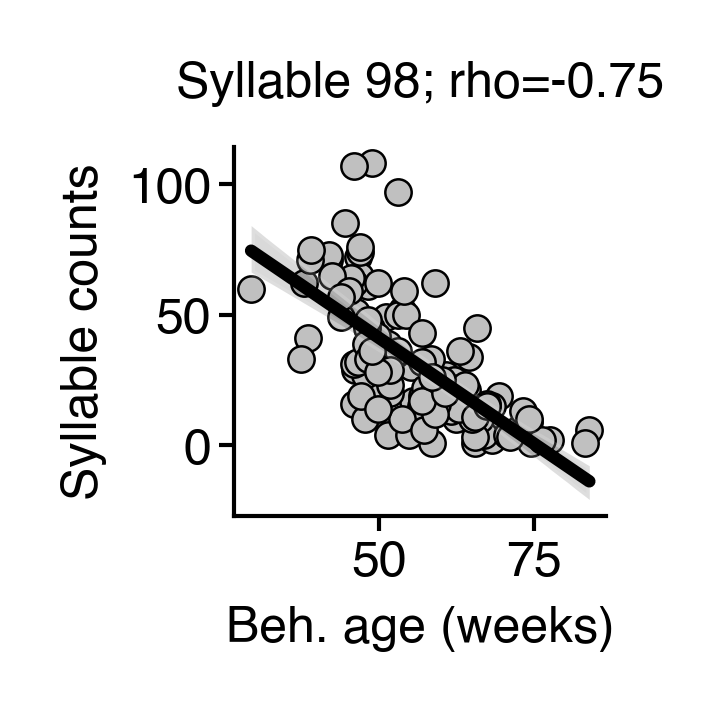

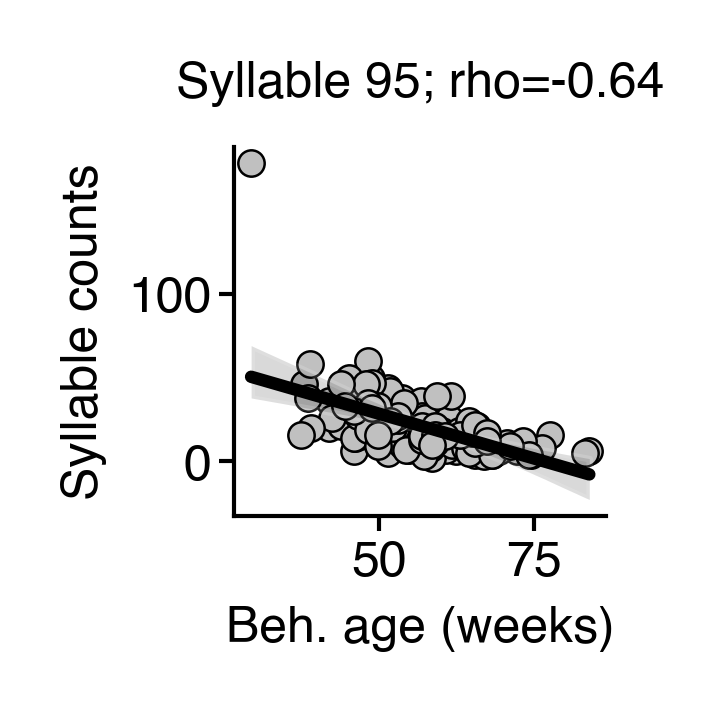

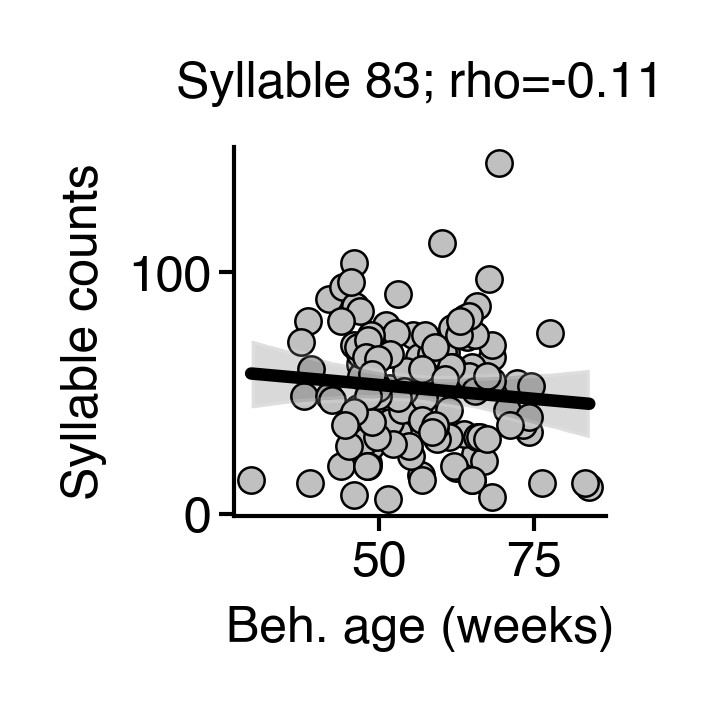

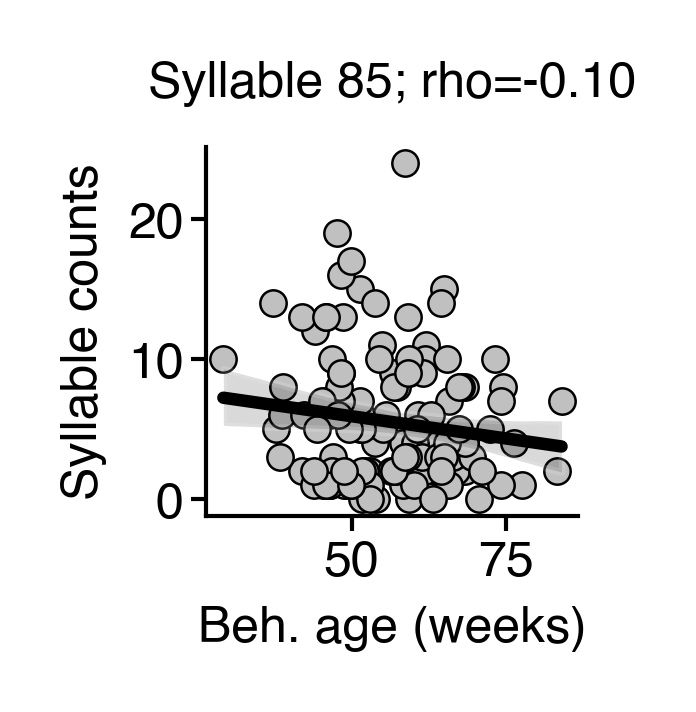

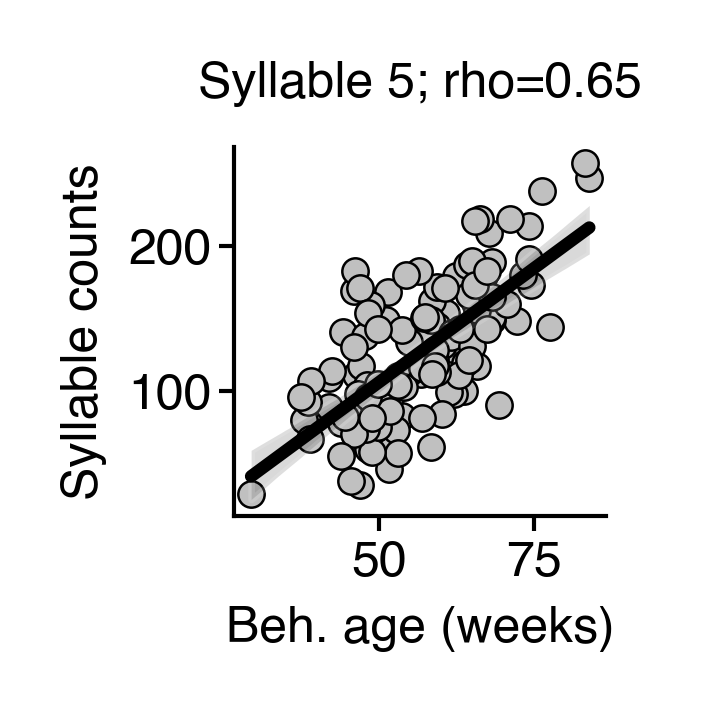

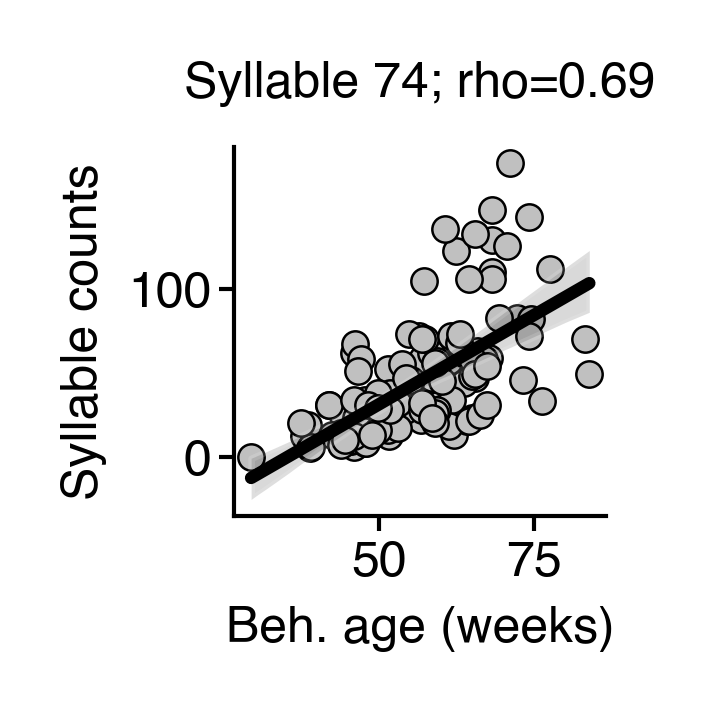

In [52]:
for syll in lm_corrs.index[[0, 1, 35, 36, -2, -1]]:
    fig = figure(0.8, 0.8)
    syll_corr = lm_corrs[syll]
    ax = sns.regplot(
        data=subset_join,
        y=syll,
        x="beh_age",
        scatter_kws=dict(s=10, linewidths=0.3, color="silver", edgecolor="k", alpha=1),
        color="k",
    )
    ax.set(
        title=f"Syllable {syll}; rho={syll_corr:0.2f}",
        xlabel="Beh. age (weeks)",
        ylabel="Syllable counts",
    )
    sns.despine()
    saver(fig, f"syll-{syll}-bambi-age-vs-counts")

## Non log-transformed

In [91]:
hyp_copy = deepcopy(hypparams)
hyp_copy['age_sd'] = 5
hyp_copy['log_age'] = False
hyp_copy['log_scale_sd'] = False

In [92]:
mdl = fit_model(features, hyp_copy, 5, return_loss_on_error=True)
tmp_df['beh_age'] = mdl['bio_ages']

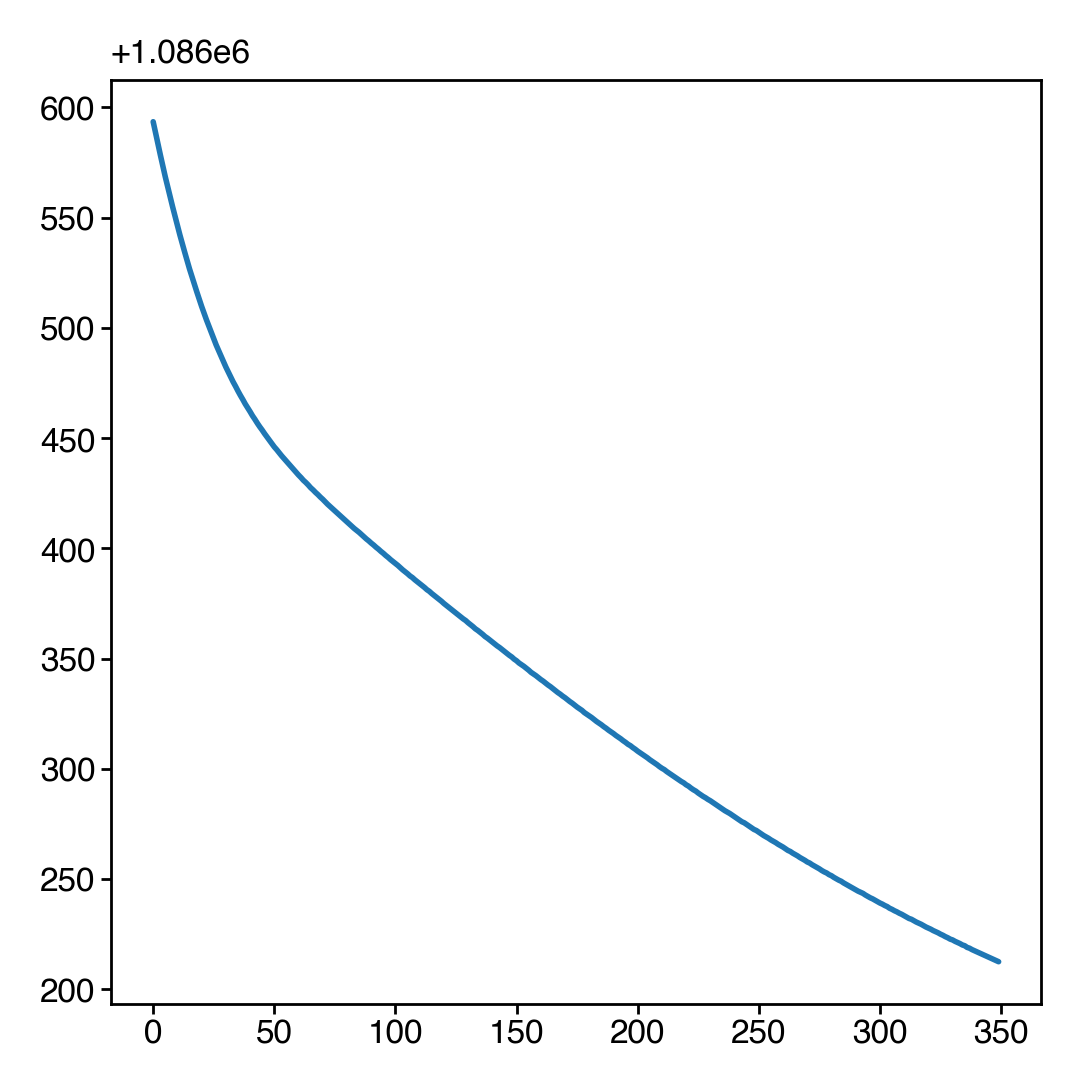

In [93]:
plt.plot(mdl['loss'][100:])

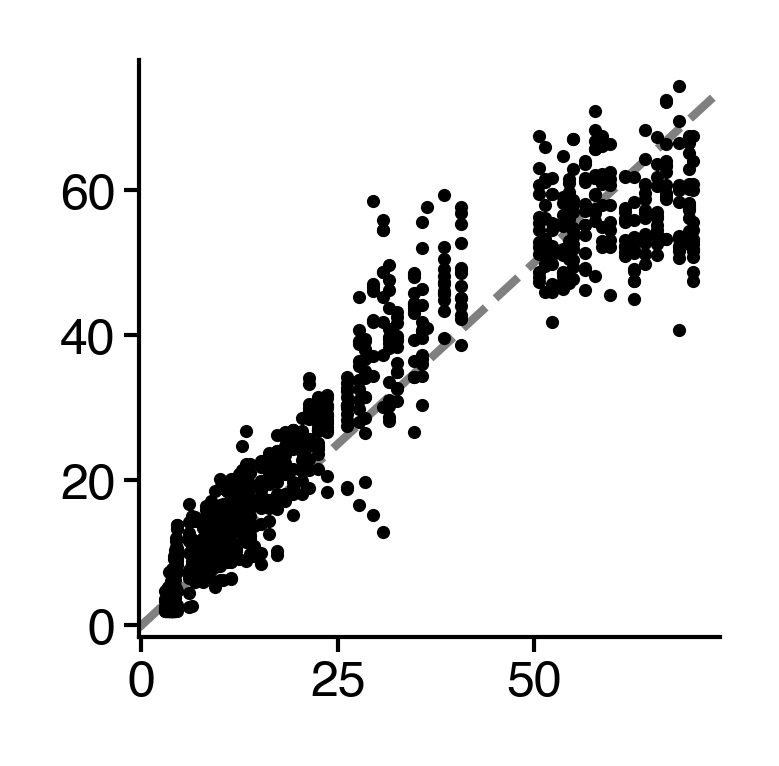

In [94]:
fig = figure(1.25, 1.25)
plt.scatter(mdl['true_ages'], mdl['bio_ages'], c='k', s=2.5, lw=0)
a = add_identity(plt.gca(), c='gray', ls='--', zorder=-1)
sns.despine()

## Try classifying early/late death times 

In [95]:
n_classes = 4

reset_df = tmp_df.reset_index()

joined = reset_df.merge(
    death_map.reset_index(), left_on="mouse", right_on="id"
).dropna(subset=["Death"])

classes = pd.qcut(joined["Death"], n_classes, labels=False)
joined['classes'] = classes

Observed fit
4 0.31


  0%|          | 0/100 [00:00<?, ?it/s]

Shuffle fit
4 -0.04


/tmp/ipykernel_27656/126220500.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=["Observed", "Shuffle"], ylabel="Held-out accuracy", ylim=(0.11, 0.45))


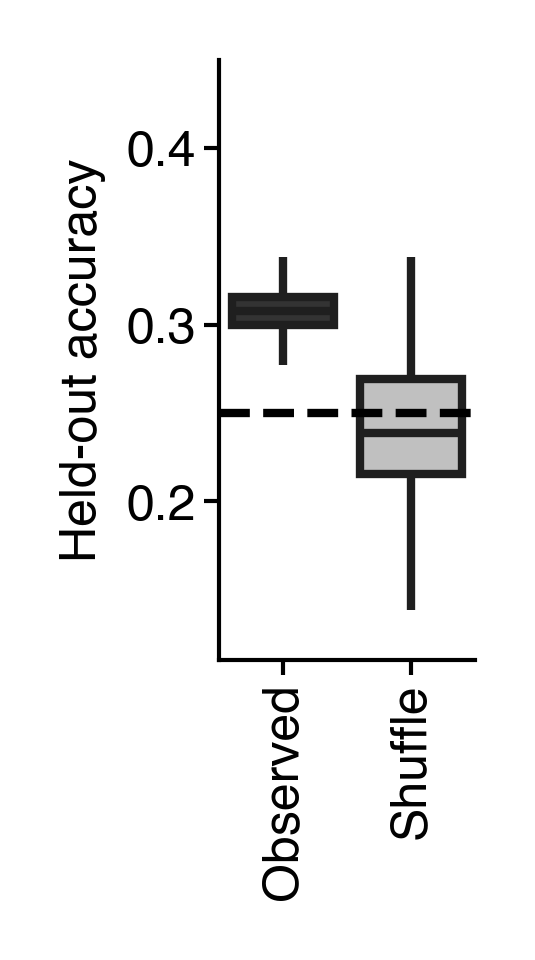

In [97]:
subset = joined[joined['age'].between(56, 71)]
accs, shuffs = fit_classifier(subset)
plot_model(accs, shuffs, "death-rank-classifier-via-bambi-no-log-xform")

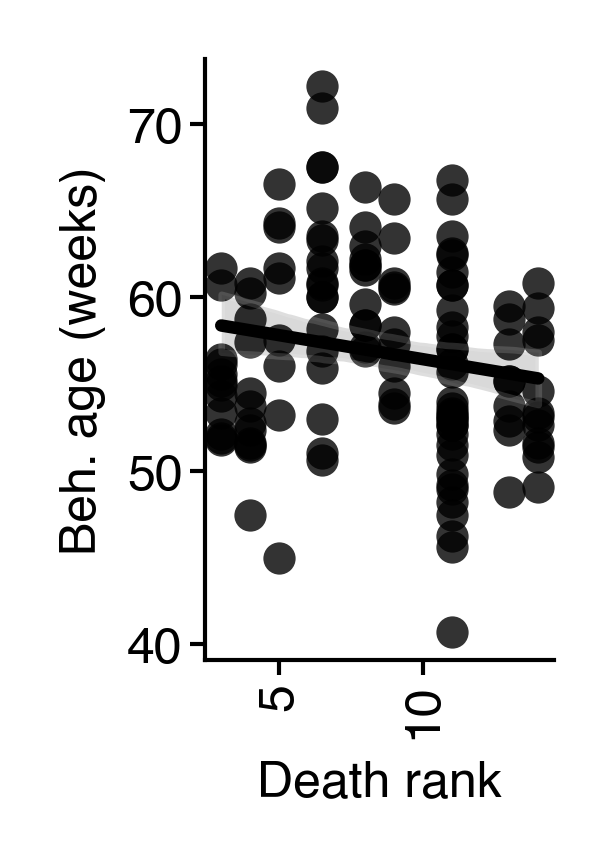

In [98]:
fig = figure(0.75, 1.3)
ax = sns.regplot(data=subset, x='death_rank', y='beh_age', scatter_kws=dict(s=15, linewidths=0), color='k')
ax.set(ylabel="Beh. age (weeks)", xlabel="Death rank")#, xticks=[0, 1, 2, 3], xticklabels=['Early', '', '', 'Late'])
ax.tick_params(axis='x', rotation=90)
sns.despine()

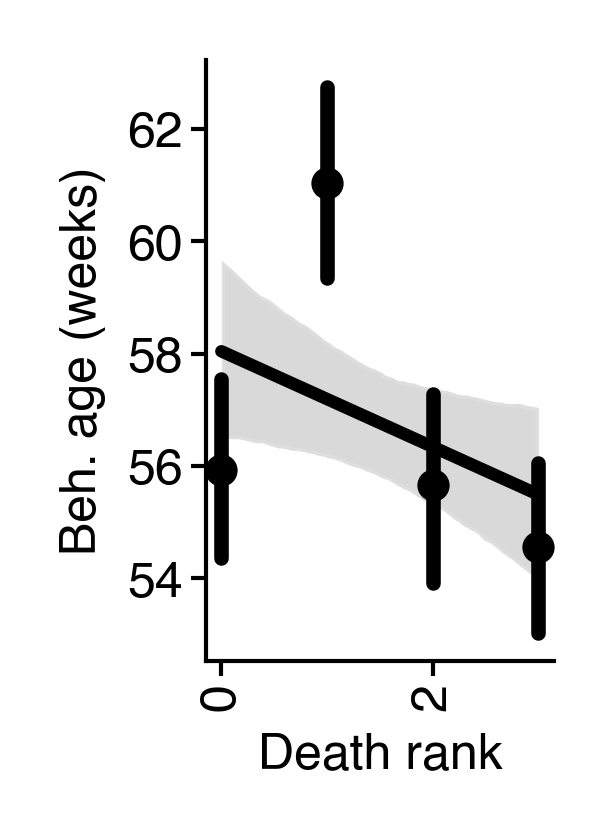

In [102]:
fig = figure(0.75, 1.3)
ax = sns.regplot(data=subset, x='classes', y='beh_age', x_bins=6, scatter_kws=dict(s=15, linewidths=0), color='k')
ax.set(ylabel="Beh. age (weeks)", xlabel="Death rank")#, xticks=[0, 1, 2, 3], xticklabels=['Early', '', '', 'Late'])
ax.tick_params(axis='x', rotation=90)
sns.despine()

### Younger ages

Observed fit
4 -0.21


  0%|          | 0/100 [00:00<?, ?it/s]

Shuffle fit
4 -0.06


/tmp/ipykernel_27656/126220500.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=["Observed", "Shuffle"], ylabel="Held-out accuracy", ylim=(0.11, 0.45))


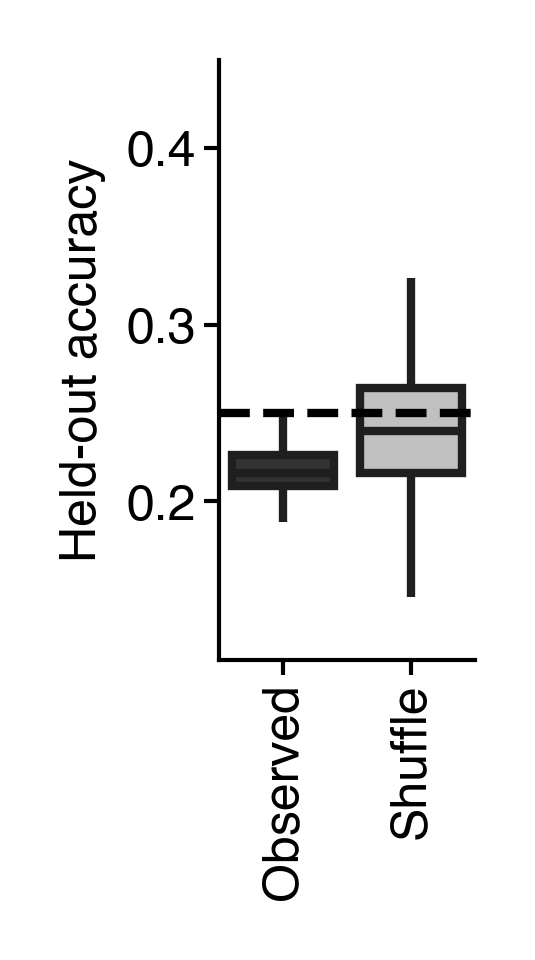

In [38]:
subset = joined[joined['age'].between(0, 20)]
accs, shuffs = fit_classifier(subset)
plot_model(accs, shuffs, "young-age-death-rank-classifier-via-bambi")

### Middler ages

Observed fit
4 0.27


  0%|          | 0/100 [00:00<?, ?it/s]

Shuffle fit
4 -0.03


/tmp/ipykernel_27656/126220500.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=["Observed", "Shuffle"], ylabel="Held-out accuracy", ylim=(0.11, 0.45))


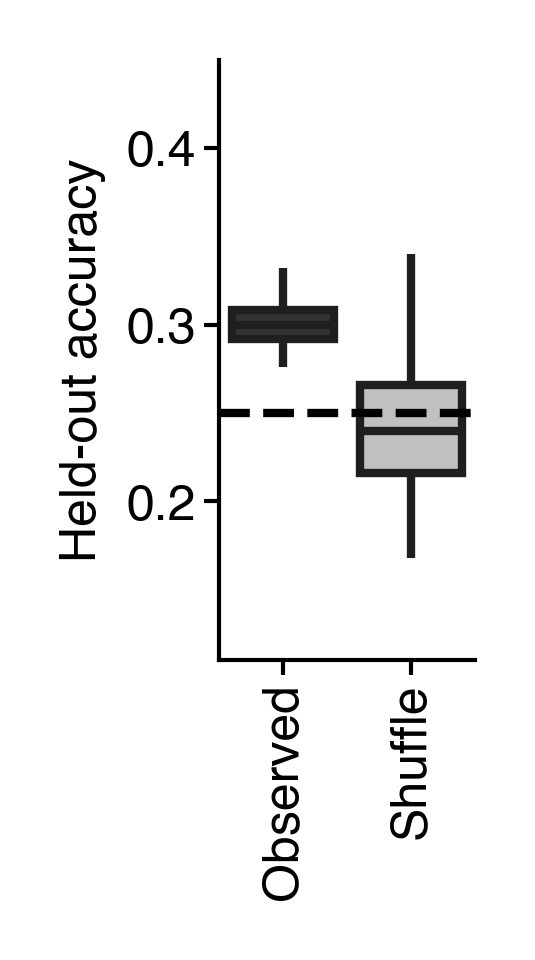

In [39]:
subset = joined[joined['age'].between(20, 56)]
accs, shuffs = fit_classifier(subset)
plot_model(accs, shuffs, "mid-age-death-rank-classifier-via-bambi")